# Hello, World! (Linear regression)

In this recipe we will learn how to:
1. Sample data using `jax.random`
2. Fit a linear model using `jax.numpy` and get standard errors for our parameters
3. Use JAX compilation and parallelism to bootstrap our model and validate theoretical standard errors


In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")

## Generating data

Let's sample data for a typical linear model $y = X \beta + \epsilon$ with $n$ samples and $p$ predictors.
$X$ and $\beta$ will be considered fixed, but synthesized using a standard normal distribution.

$\epsilon$ is random following a normal distribution $N(0, \sigma^2)$.

In [3]:
key = random.PRNGKey(20220519)

n = 100
p = 4
sigma = .1

key, skey = random.split(key)
beta=random.normal(skey, (p,))

key, skey = random.split(key)
x = random.normal(skey, (n, p))

def sample_y(key, beta, sigma, x):
    eps = random.normal(key, (n,))
    return x @ beta + sigma * eps

key, skey = random.split(key)
y = sample_y(skey, beta, sigma, x)

Here is our first encounter with JAX random number generator!
Due to a variety of reasons, JAX prefers to have an explicit random state that needs to be passed to every function that samples random numbers.
Prior to sending that random state, the key needs to be split in two, generating a new key and a sub key. The sub-key will be used immediately, the new key will be kept for further splitting later.

For more details, see [JAX Random numbers](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers)


At this point, we have data that follows a linear model.
We can inspect it using pair-wise plots:

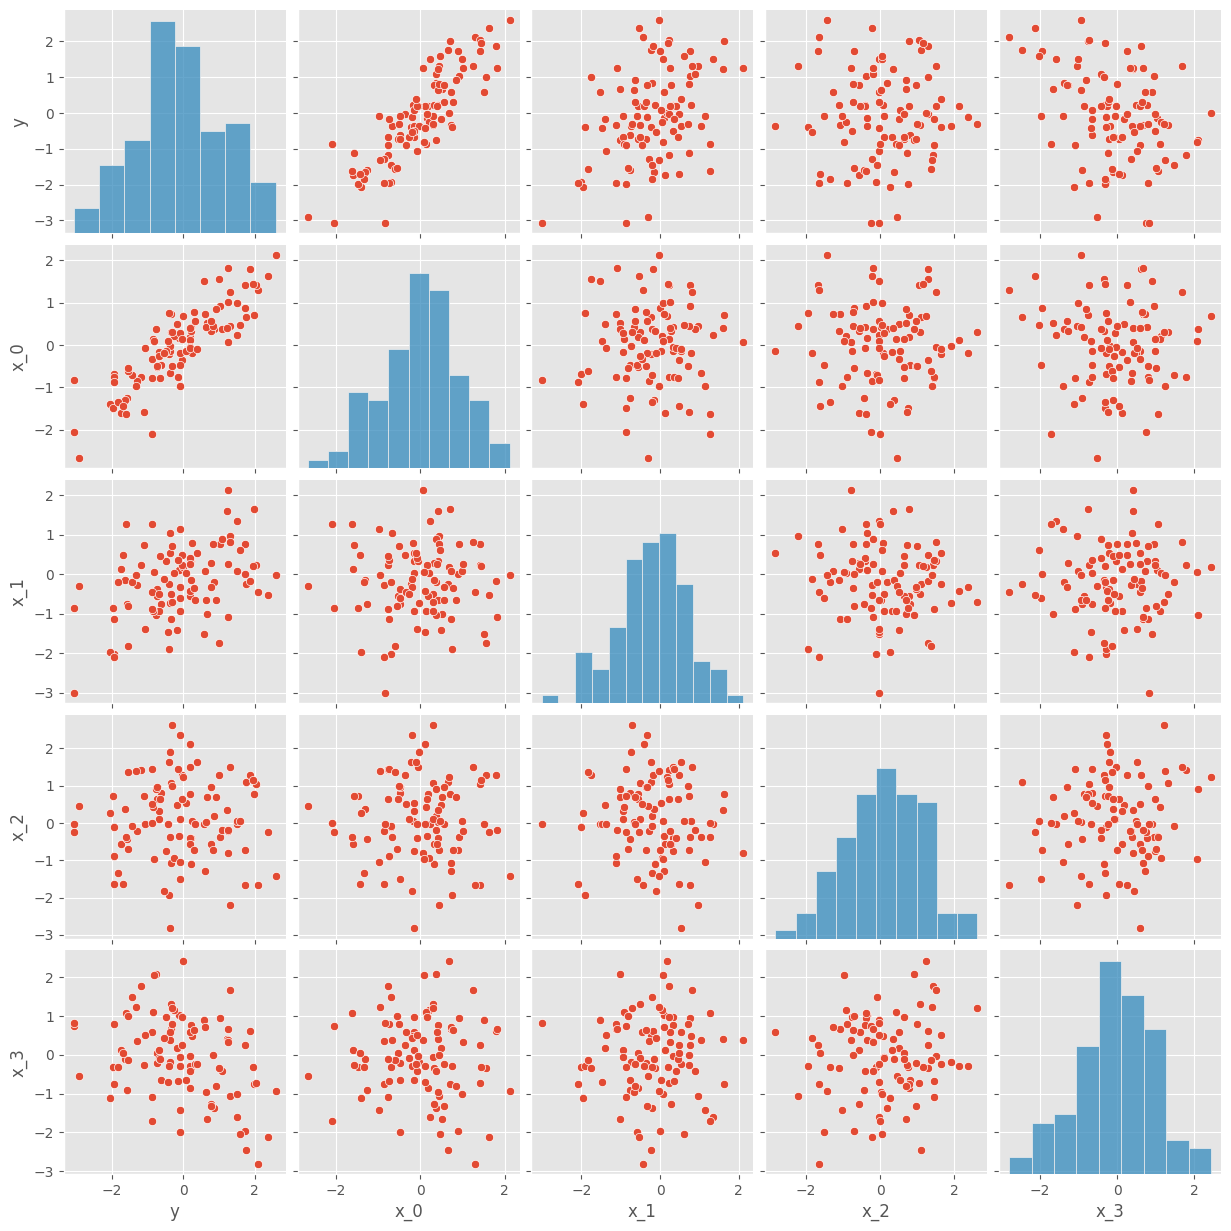

beta=DeviceArray([ 1.1385529 ,  0.5513186 ,  0.08600916, -0.385452  ], dtype=float32)


In [54]:
df = pd.DataFrame({'y': y, **{f'x_{i}': x[:, i] for i in range(p)}})
sns.pairplot(df)
plt.show()
print(f"{beta=}")

$X_0$ is in particular a strong predictor of y, as is also suggested by $\beta_0$.

## Fitting the model using OLS

Now let's assume we don't know the real $\beta$ and need to estimate it from the data.
We will see how to leverage JAX optimization routines to maximize generic likelihood functions efficiently in a later recipe.
For now, let's focus on using the linear model theory (Ordinary least squares) and linear algebra to get what we want.

$\hat\beta = (X^TX)^{-1}X^Ty$

Thankfully, using JAX numpy API, any numpy afficionado can write the following:

In [14]:
def fit_beta(x, y):
    z = x.T @ y
    beta_hat = jnp.linalg.solve(x.T @ x, z)
    return beta_hat

beta_hat = fit_beta(x, y)
beta_hat / beta

DeviceArray([0.9884359, 1.0327826, 1.0761149, 0.9873783], dtype=float32)

$\hat\beta$ is indeed within a few percent of $\beta$

Let's also use the theory to get standard errors for our estimates.


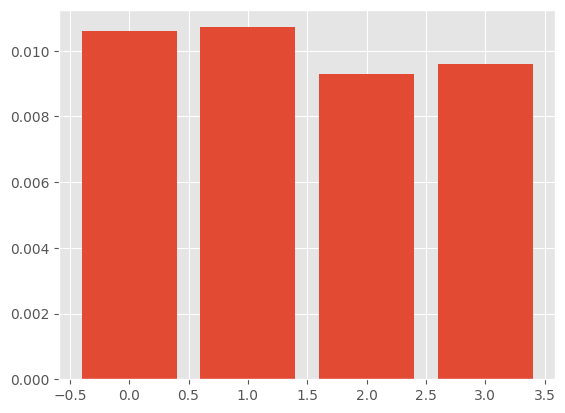

In [50]:
def get_beta_std(x, y, beta):
    y_hat = x @ beta
    eps_hat = y - y_hat
    sigma2_hat = eps_hat.dot(eps_hat) / (n - p)
    beta_std = jnp.sqrt(jnp.diag(sigma2_hat * jnp.linalg.inv(x.T @ x)))
    return beta_std

beta_std = get_beta_std(x, y, beta_hat)
plt.bar(range(p), beta_std)
plt.show()

Looks like the standard error on each estimate is close to 1%.
We could also look at the full covariance matrix to check that each component is not correlated with the other, since the $\beta$'s were generated as independent.


## Speed up and validate by boostrapping

Ok, so far we could have used scipy to generate the data, and numpy for the linear algebra, so why use JAX?
In this section, we will demonstrate two useful tools:
1. Just-in-time compilation (https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)
2. Parallelism (https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html)

First, if we want to bootstrap, we probably want the fastest code possible that generates data, and fits the data.
Let's gather what we've learned in a function and test it.


In [22]:
def replicate(key, beta, sigma, x):
    y = sample_y(key, beta, sigma, x)
    beta_hat = fit_beta(x, y)
    return beta_hat

key, skey = random.split(key)
replicate(key, beta, sigma, x)

DeviceArray([ 1.1166962 ,  0.55291855,  0.08377122, -0.38438013], dtype=float32)

In [23]:
%%timeit
replicate(key, beta, sigma, x)

255 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


A single replication takes about 250 µs. Not bad. It should be about as fast as "vanilla" numpy.

In [28]:
jit_replicate = jax.jit(replicate)
jit_replicate(key, beta, sigma, x) # Execute once to compile it


DeviceArray([ 1.1166962 ,  0.5529185 ,  0.0837712 , -0.38438007], dtype=float32)

In [29]:
%%timeit
jit_replicate(key, beta, sigma, x)

10.7 µs ± 84.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


After compilation, a single replication takes about 10 µs. 25 times faster!

Now that a single replication is fast, how do we replicate a high number of times?

In [43]:
%%time
# Option 1: for loop
n_replications = 100_000
key, *skeys = random.split(key, n_replications + 1)
beta_s = []
for key in skeys:
    beta_s.append(jit_replicate(key, beta, sigma, x))


CPU times: user 1.99 s, sys: 22.7 ms, total: 2.01 s
Wall time: 2 s


In [44]:
%%time
# Option 2: JAX vectorization / parallelism

n_replications = 100_000
key, skey = random.split(key)
skeys = random.split(skey, n_replications)

boostrap = jax.jit( # Enable JIT compilation
    jax.vmap( # Vectorize "replicate"
        replicate,
        in_axes=(0, None, None, None) # Only the first argument will be batched, on it's first (0th) axis
    )
)
beta_s = boostrap(skeys, beta, sigma, x)

CPU times: user 1.18 s, sys: 1.13 s, total: 2.31 s
Wall time: 751 ms


As we can see, JAX vectorization by `vmap` reduces computation time by a factor 2 compared to a Python for loop.
Compilation introduces a fixed cost, so a higher number of replications, or larger data would likely widen that gap.
Note that it is recommended to `jit` on the outer-most function, which is why we want back to use `replicate` and not `jit_replicate`.


Did we achieve what we set out to? Let's compare standard errors from bootstrap and OLS.


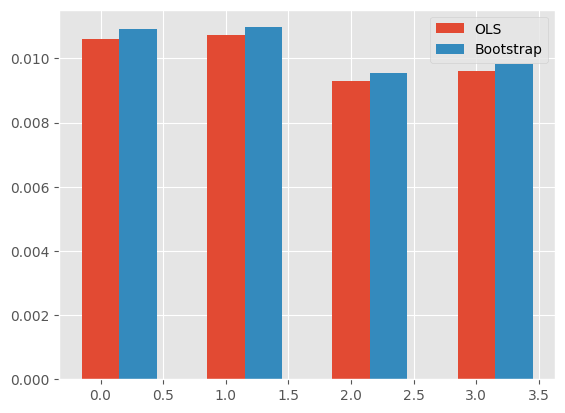

In [53]:
beta_std_bootstrap = beta_s.std(axis=0)

width = .3
plt.bar(jnp.arange(p), beta_std, width=width, label='OLS')
plt.bar(jnp.arange(p) + width, beta_std_bootstrap, width=width, label='Bootstrap')
plt.legend()
plt.show()

Estimates by bootstrap are likely a bit more accurate, but we can see that both methods align very well, and that any inference based on those would agree.

## Conclusion

In this recipe we discovered how JAX API ressembles numpy and scipy, while introducing two major features brought by JAX:
1. JIT compilation will allow us to build more complex models on bigger data while keeping really high performance, something that Python and R can sometimes struggle with.
2. Automatic vectorization will allow us to test our models at a larger scale by vectorizing complex functions and business logic without having to write every function in a vectorized way (as sometimes, you simply can't).

